In [2]:
import numpy as np
import pandas as pd
import json

In [3]:
path_results = "test_results/20A_20C_14Sept_CPU/" #20A_20C_06Sept_20EPO #20A_20B_17Sept_CPU

In [4]:
def read_json(file_path):
    with open(file_path) as file:
        return json.loads(file.read())

In [5]:
f_dict = read_json(path_results + "f_word_dictionaries.json")
#f_dict

In [6]:
r_dict = read_json(path_results + "r_word_dictionaries.json")
#r_dict

In [7]:
def read_txt(file_path):
    data = None
    with open(file_path) as file:
        data = file.read()
    data = data.split("\n")
    data = data[:len(data) - 1]
    data = [float(i) for i in data]
    return data

In [8]:
tr_gen_true_loss = read_txt(path_results + "tr_gen_true_loss.txt")
tr_gen_fake_loss = read_txt(path_results + "tr_gen_fake_loss.txt")
tr_gen_total_loss = read_txt(path_results + "tr_gen_total_loss.txt")

tr_disc_total_loss = read_txt(path_results + "tr_disc_total_loss.txt")
tr_disc_fake_loss = read_txt(path_results + "tr_disc_fake_loss.txt")
tr_disc_true_loss = read_txt(path_results + "tr_disc_true_loss.txt")
te_loss = read_txt(path_results + "te_loss.txt")
te_loss
n_epochs = len(tr_gen_true_loss)
epochs = np.arange(0, n_epochs)

In [9]:
te_loss

[4.083708763122559,
 4.717136859893799,
 5.455147743225098,
 1.4450117349624634,
 0.2105913609266281,
 0.15814128518104553,
 0.1448821723461151,
 0.008961454965174198,
 0.09326361864805222,
 0.00835699588060379]

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

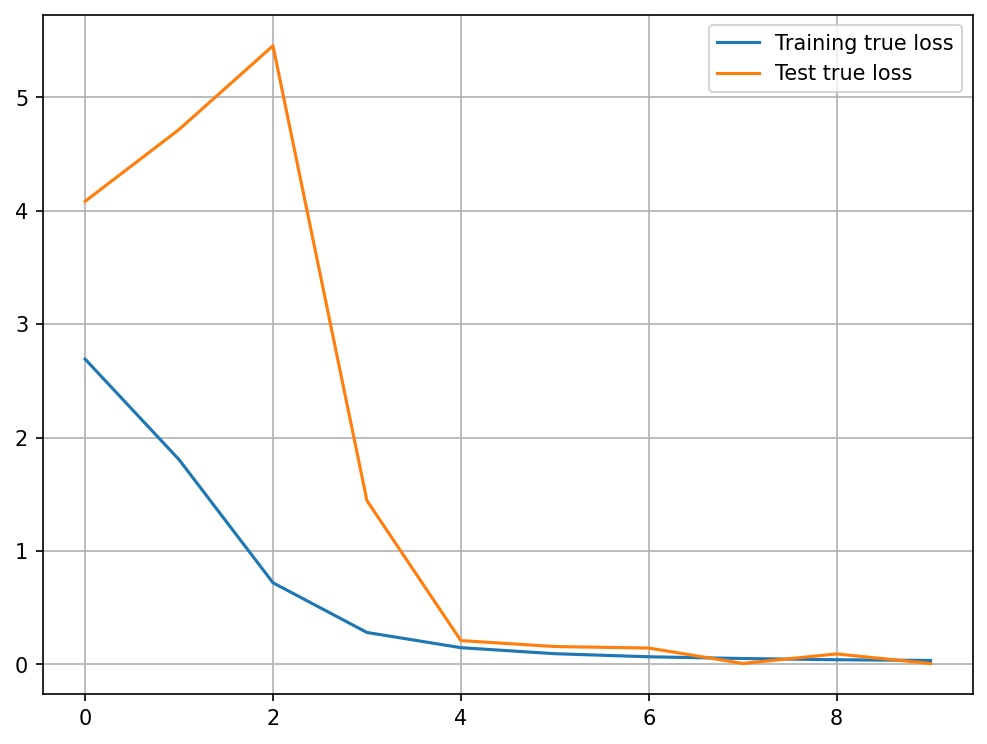

In [11]:
plt.figure(figsize=(8, 6), dpi=150)

plt.plot(epochs, tr_gen_true_loss)
plt.plot(epochs, te_loss)

plt.legend(["Training true loss", "Test true loss"])
plt.grid(True)
plt.show()

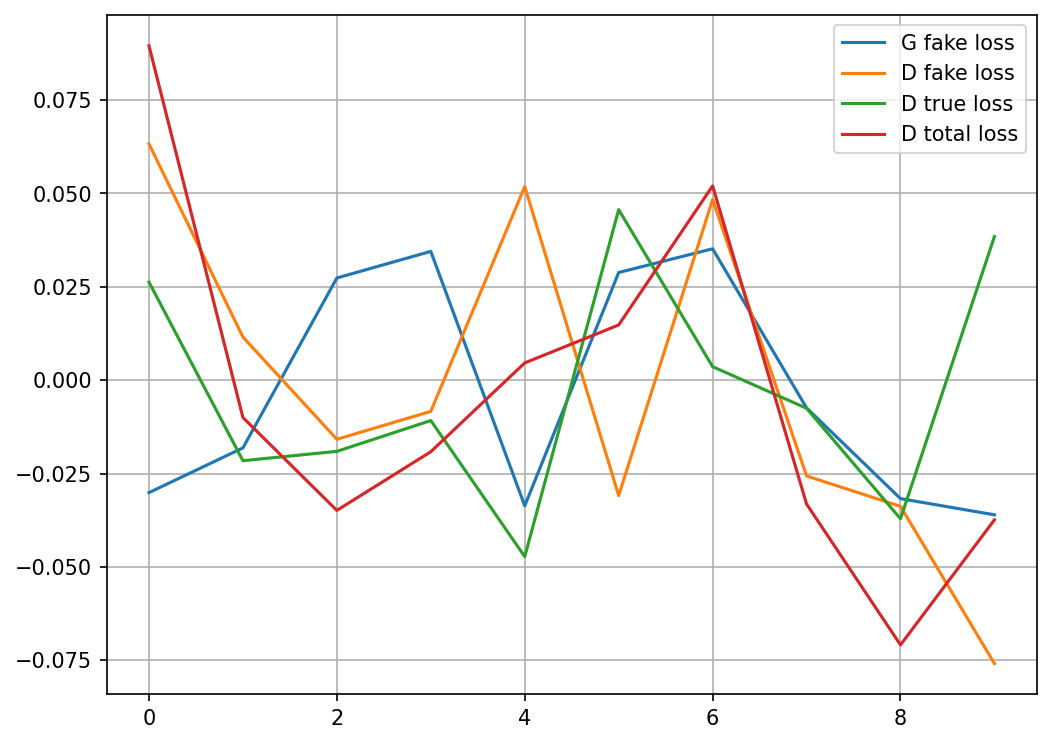

In [12]:
plt.figure(figsize=(8, 6), dpi=150)

plt.plot(epochs, tr_gen_fake_loss)
plt.plot(epochs, tr_disc_fake_loss)
plt.plot(epochs, tr_disc_true_loss)
plt.plot(epochs, tr_disc_total_loss)

plt.legend(["G fake loss", "D fake loss", "D true loss", "D total loss"])
plt.grid(True)
plt.show()

In [13]:
import json
epo = 10
# ave_batch_x_y_mut_epo_0

mut_freq = dict()

for e in range(epo):
    f_name = "{}ave_batch_x_y_mut_epo_{}.json".format(path_results, str(e))
    with open(f_name, "r") as f:
        mut_dict = json.loads(f.read())
        for key in mut_dict:
            if key not in mut_freq:
                mut_freq[key] = int(mut_dict[key])
            else:
                mut_freq[key] += mut_dict[key]

In [14]:
len(mut_freq), mut_freq

(45,
 {'8>5': 1721,
  '13>19': 2841,
  '5>8': 2002,
  '5>19': 1384,
  '5>17': 1475,
  '18>15': 1672,
  '4>14': 1683,
  '17>12': 1563,
  '19>11': 3002,
  '1>3': 1594,
  '2>3': 4182,
  '19>8': 1441,
  '6>17': 1399,
  '14>6': 1425,
  '1>11': 1792,
  '12>10': 3127,
  '19>12': 1657,
  '14>16': 1545,
  '18>7': 1442,
  '17>5': 1438,
  '10>12': 2022,
  '13>17': 1694,
  '8>6': 1564,
  '7>18': 1432,
  '2>12': 1361,
  '17>13': 2757,
  '14>1': 1516,
  '2>10': 1437,
  '12>9': 1409,
  '17>15': 1595,
  '1>16': 1665,
  '16>6': 2187,
  '16>1': 1523,
  '2>17': 1435,
  '18>16': 1918,
  '2>7': 2879,
  '15>19': 2884,
  '19>15': 1811,
  '17>10': 1615,
  '3>14': 1398,
  '17>2': 1403,
  '8>17': 1438,
  '16>14': 1515,
  '10>3': 1405,
  '19>13': 2474})

In [15]:
mut_freq_aa_keys = dict()
print(f_dict)
for key in mut_freq:
    key_split = key.split(">")
    aa_key = "{}>{}".format(f_dict[key_split[0]], f_dict[key_split[1]])
    mut_freq_aa_keys[aa_key] = mut_freq[key] / float(epo)

{'1': 'Q', '2': 'N', '3': 'K', '4': 'W', '5': 'F', '6': 'P', '7': 'Y', '8': 'L', '9': 'M', '10': 'T', '11': 'E', '12': 'I', '13': 'A', '14': 'R', '15': 'G', '16': 'H', '17': 'S', '18': 'D', '19': 'V', '20': 'C'}


In [16]:
mut_freq_aa_keys = {k: v for k, v in sorted(mut_freq_aa_keys.items(), key=lambda item: item[1], reverse=True)}

In [17]:
mut_freq_aa_keys

{'N>K': 418.2,
 'I>T': 312.7,
 'V>E': 300.2,
 'G>V': 288.4,
 'N>Y': 287.9,
 'A>V': 284.1,
 'S>A': 275.7,
 'V>A': 247.4,
 'H>P': 218.7,
 'T>I': 202.2,
 'F>L': 200.2,
 'D>H': 191.8,
 'V>G': 181.1,
 'Q>E': 179.2,
 'L>F': 172.1,
 'A>S': 169.4,
 'W>R': 168.3,
 'D>G': 167.2,
 'Q>H': 166.5,
 'V>I': 165.7,
 'S>T': 161.5,
 'S>G': 159.5,
 'Q>K': 159.4,
 'L>P': 156.4,
 'S>I': 156.3,
 'R>H': 154.5,
 'H>Q': 152.3,
 'R>Q': 151.6,
 'H>R': 151.5,
 'F>S': 147.5,
 'D>Y': 144.2,
 'V>L': 144.1,
 'S>F': 143.8,
 'L>S': 143.8,
 'N>T': 143.7,
 'N>S': 143.5,
 'Y>D': 143.2,
 'R>P': 142.5,
 'I>M': 140.9,
 'T>K': 140.5,
 'S>N': 140.3,
 'P>S': 139.9,
 'K>R': 139.8,
 'F>V': 138.4,
 'N>I': 136.1}

In [115]:
tr_A_C_par_child_mut_pos = read_json(path_results + "tr_parent_child_pos.json")
A_C_par_child_mut_pos = read_json(path_results + "parent_child_pos.json")
merged_A_C_par_child_mut_pos = {**tr_A_C_par_child_mut_pos, **A_C_par_child_mut_pos}
print(len(tr_A_C_par_child_mut_pos), len(A_C_par_child_mut_pos), len(merged_A_C_par_child_mut_pos))
A_C_par_gen_mut_pos = read_json(path_results + "parent_gen_pos.json")

77 358 434


In [116]:
print(len(merged_A_C_par_child_mut_pos), merged_A_C_par_child_mut_pos)

434 {'V>701>A': 588, 'S>477>N': 356, 'N>439>K': 344, 'A>522>V': 271, 'V>769>G': 251, 'F>98>S': 249, 'V>281>E': 231, 'H>681>P': 229, 'D>253>G': 175, 'L>1162>P': 159, 'I>20>T': 157, 'I>76>T': 156, 'F>18>L': 148, 'D>936>Y': 128, 'W>152>R': 98, 'A>626>S': 97, 'V>407>I': 95, 'A>570>V': 92, 'S>477>I': 92, 'N>1187>Y': 91, 'I>68>T': 90, 'T>259>I': 90, 'Q>677>H': 90, 'Q>954>K': 90, 'T>20>I': 89, 'S>261>G': 88, 'V>976>I': 88, 'I>19>T': 88, 'S>771>A': 85, 'S>67>A': 83, 'R>1201>Q': 83, 'Q>675>H': 83, 'T>572>I': 83, 'H>675>Q': 83, 'S>348>A': 82, 'S>575>A': 80, 'S>879>A': 80, 'S>27>A': 80, 'R>681>P': 79, 'R>66>H': 79, 'I>676>T': 79, 'F>865>L': 79, 'V>1078>A': 78, 'N>558>K': 76, 'I>572>T': 70, 'F>6>V': 68, 'V>1122>L': 67, 'H>251>P': 66, 'T>210>I': 66, 'S>701>A': 66, 'Q>1111>E': 65, 'Y>138>D': 65, 'P>1162>S': 65, 'I>95>T': 65, 'A>704>S': 64, 'N>477>S': 64, 'D>215>H': 63, 'N>501>Y': 63, 'L>54>F': 63, 'A>1020>V': 63, 'I>33>T': 1, 'S>459>F': 63, 'I>153>M': 62, 'T>478>K': 60, 'L>5>F': 59, 'D>1163>Y': 58, 

In [117]:
print(len(tr_A_C_par_child_mut_pos), tr_A_C_par_child_mut_pos)

77 {'V>701>A': 588, 'S>477>N': 356, 'N>439>K': 344, 'A>522>V': 271, 'V>769>G': 251, 'F>98>S': 249, 'V>281>E': 231, 'H>681>P': 229, 'D>253>G': 175, 'L>1162>P': 159, 'I>20>T': 157, 'I>76>T': 156, 'F>18>L': 148, 'D>936>Y': 128, 'W>152>R': 98, 'A>626>S': 97, 'V>407>I': 95, 'A>570>V': 92, 'S>477>I': 92, 'N>1187>Y': 91, 'I>68>T': 90, 'T>259>I': 90, 'Q>677>H': 90, 'Q>954>K': 90, 'T>20>I': 89, 'S>261>G': 88, 'V>976>I': 88, 'I>19>T': 88, 'S>771>A': 85, 'S>67>A': 83, 'R>1201>Q': 83, 'Q>675>H': 83, 'T>572>I': 83, 'H>675>Q': 83, 'S>348>A': 82, 'S>575>A': 80, 'S>879>A': 80, 'S>27>A': 80, 'R>681>P': 79, 'R>66>H': 79, 'I>676>T': 79, 'F>865>L': 79, 'V>1078>A': 78, 'N>558>K': 76, 'I>572>T': 70, 'F>6>V': 68, 'V>1122>L': 67, 'H>251>P': 66, 'T>210>I': 66, 'S>701>A': 66, 'Q>1111>E': 65, 'Y>138>D': 65, 'P>1162>S': 65, 'I>95>T': 65, 'A>704>S': 64, 'N>477>S': 64, 'D>215>H': 63, 'N>501>Y': 63, 'L>54>F': 63, 'A>1020>V': 63, 'I>33>T': 63, 'S>459>F': 63, 'I>153>M': 62, 'T>478>K': 60, 'L>5>F': 59, 'D>1163>Y': 58, 

In [118]:
print(len(A_C_par_child_mut_pos), A_C_par_child_mut_pos)

358 {'I>67>T': 2, 'N>86>K': 2, 'A>1>S': 1, 'S>1>A': 1, 'L>2>P': 1, 'T>3>I': 1, 'S>3>A': 1, 'I>4>T': 1, 'I>5>M': 1, 'S>6>G': 1, 'T>7>K': 1, 'F>8>S': 1, 'N>9>Y': 1, 'V>10>E': 1, 'V>11>A': 1, 'Q>12>K': 1, 'W>13>R': 1, 'H>13>Q': 1, 'I>14>T': 1, 'V>14>E': 1, 'S>15>A': 1, 'W>16>R': 1, 'I>17>T': 1, 'S>18>N': 1, 'A>19>V': 1, 'R>20>Q': 1, 'N>21>K': 1, 'V>21>G': 1, 'N>22>T': 1, 'V>23>G': 1, 'A>24>S': 1, 'D>25>Y': 1, 'N>26>K': 1, 'A>27>V': 1, 'V>27>A': 1, 'T>28>I': 1, 'N>28>K': 1, 'R>29>H': 1, 'F>30>L': 1, 'T>31>I': 1, 'F>32>L': 1, 'I>33>T': 1, 'Q>33>H': 1, 'S>34>I': 1, 'T>35>I': 1, 'T>36>I': 1, 'S>36>A': 1, 'G>37>V': 1, 'V>38>A': 1, 'L>39>F': 1, 'N>39>K': 1, 'I>40>T': 1, 'I>41>T': 1, 'N>42>K': 1, 'R>42>Q': 1, 'N>43>K': 1, 'V>44>I': 1, 'S>45>A': 1, 'P>46>S': 1, 'F>47>V': 1, 'V>48>L': 1, 'S>49>A': 1, 'N>49>K': 1, 'I>50>T': 1, 'H>50>P': 1, 'N>51>K': 1, 'L>51>P': 1, 'D>52>G': 1, 'T>53>I': 1, 'D>54>H': 1, 'N>54>Y': 1, 'I>55>T': 1, 'A>55>S': 1, 'A>56>V': 1, 'F>56>L': 1, 'Q>57>H': 1, 'S>58>F': 1, 'H>59

In [119]:
print(len(A_C_par_gen_mut_pos), A_C_par_gen_mut_pos)

198 {'S>1>A': 1, 'L>2>P': 1, 'T>3>I': 1, 'S>3>A': 1, 'I>4>T': 1, 'I>5>M': 1, 'S>6>G': 1, 'F>8>S': 1, 'V>10>E': 1, 'V>11>A': 1, 'H>13>Q': 1, 'V>14>E': 1, 'S>15>A': 1, 'I>17>T': 1, 'R>20>Q': 1, 'V>21>G': 1, 'V>23>G': 1, 'V>27>A': 1, 'N>28>K': 1, 'R>29>H': 1, 'F>30>L': 1, 'F>32>L': 1, 'I>33>T': 1, 'S>36>A': 1, 'K>37>N': 1, 'R>37>P': 1, 'V>38>A': 1, 'I>40>T': 1, 'I>41>T': 1, 'R>42>Q': 1, 'N>43>K': 1, 'S>45>A': 1, 'F>47>V': 1, 'S>49>A': 1, 'I>50>T': 1, 'H>50>P': 1, 'L>51>P': 1, 'I>55>T': 1, 'A>55>S': 1, 'F>56>L': 1, 'H>59>P': 1, 'S>60>A': 1, 'H>62>Q': 1, 'R>63>P': 1, 'I>64>T': 1, 'V>65>E': 1, 'Q>65>E': 1, 'I>66>T': 1, 'I>67>T': 1, 'S>68>A': 1, 'N>69>S': 1, 'I>70>T': 1, 'S>71>A': 1, 'Y>72>D': 1, 'S>73>A': 1, 'S>74>A': 1, 'S>75>A': 1, 'F>76>L': 1, 'H>76>P': 1, 'V>77>A': 1, 'R>78>H': 1, 'I>79>T': 1, 'I>80>T': 1, 'F>82>L': 1, 'I>83>T': 1, 'I>85>T': 1, 'N>86>K': 1, 'I>87>T': 1, 'V>88>A': 1, 'S>90>A': 1, 'S>92>A': 1, 'V>93>A': 1, 'I>94>T': 1, 'V>95>A': 1, 'K>96>N': 1, 'R>96>P': 1, 'S>96>A': 1, 'I

In [120]:
true_mut_A_C = list(merged_A_C_par_child_mut_pos.keys()) # tr_A_C_par_child_mut_pos 
gen_mut_A_C = list(A_C_par_gen_mut_pos.keys()) 
inter_true_gen_mut_A_C = list(set(true_mut_A_C).intersection(set(gen_mut_A_C)))
print(len(inter_true_gen_mut_A_C), inter_true_gen_mut_A_C)

180 ['V>104>A', 'S>192>A', 'F>208>L', 'S>156>A', 'I>33>T', 'R>145>H', 'R>134>H', 'I>154>T', 'V>88>A', 'S>6>G', 'R>42>Q', 'I>17>T', 'S>3>A', 'R>150>Q', 'R>78>H', 'H>179>Q', 'V>38>A', 'I>183>T', 'F>171>L', 'I>182>T', 'I>200>T', 'I>138>T', 'V>10>E', 'V>191>E', 'F>32>L', 'F>76>L', 'S>211>A', 'I>66>T', 'V>195>E', 'T>3>I', 'R>153>Q', 'S>120>A', 'I>112>T', 'I>167>T', 'L>166>P', 'S>45>A', 'Y>72>D', 'I>129>T', 'S>131>A', 'V>161>G', 'I>141>T', 'I>85>T', 'S>190>A', 'I>80>T', 'L>168>P', 'I>4>T', 'F>114>L', 'I>40>T', 'I>5>M', 'I>70>T', 'S>107>A', 'H>50>P', 'V>127>G', 'S>96>A', 'S>15>A', 'F>47>V', 'I>83>T', 'S>149>G', 'V>11>A', 'I>198>T', 'V>160>A', 'I>100>T', 'I>136>T', 'N>101>K', 'V>170>E', 'F>197>L', 'R>206>H', 'I>204>T', 'S>75>A', 'I>64>T', 'I>67>T', 'F>116>L', 'H>186>P', 'H>151>P', 'L>172>P', 'H>119>P', 'V>157>A', 'F>8>S', 'R>20>Q', 'S>60>A', 'S>68>A', 'N>69>S', 'H>76>P', 'H>122>P', 'H>133>P', 'H>102>P', 'V>147>G', 'V>113>A', 'S>132>A', 'S>109>A', 'V>148>E', 'H>210>P', 'V>142>A', 'S>193>A', 'S>

In [121]:
C_c_20C_par_child_mut_pos = read_json(path_results + "mut_pos_parent_child.json")
C_c_20C_par_gen_mut_pos = read_json(path_results + "mut_pos_parent_gen.json")

In [122]:
print(len(C_c_20C_par_child_mut_pos), C_c_20C_par_child_mut_pos)

87 {'T>95>I': 2664, 'D>253>G': 2646, 'L>5>F': 2628, 'A>701>V': 1937, 'E>484>K': 1776, 'S>13>I': 1341, 'L>452>R': 1332, 'W>152>C': 1323, 'K>439>N': 1134, 'R>681>P': 901, 'S>477>N': 828, 'Q>957>R': 745, 'N>477>S': 480, 'P>26>S': 447, 'E>1258>D': 447, 'V>1251>G': 378, 'Q>935>H': 298, 'W>258>L': 298, 'Y>936>D': 216, 'V>522>A': 162, 'P>494>S': 162, 'H>681>P': 159, 'G>72>R': 149, 'G>1219>V': 149, 'A>1078>S': 149, 'D>1259>H': 149, 'D>796>H': 149, 'G>1219>S': 149, 'V>213>L': 149, 'A>942>T': 149, 'L>18>F': 149, 'D>1199>N': 149, 'A>222>V': 148, 'Q>677>P': 147, 'Q>677>H': 147, 'P>681>H': 129, 'I>20>T': 108, 'F>5>L': 108, 'Y>501>N': 108, 'I>716>T': 108, 'H>677>Q': 104, 'R>152>W': 90, 'G>253>D': 72, 'D>75>G': 54, 'S>102>R': 54, 'T>68>I': 54, 'Y>1163>D': 54, 'H>675>Q': 54, 'I>259>T': 54, 'V>570>A': 54, 'L>1122>V': 54, 'I>407>V': 54, 'I>153>M': 54, 'L>157>F': 54, 'T>501>N': 54, 'K>954>Q': 54, 'I>572>T': 54, 'K>478>T': 54, 'K>19>T': 54, 'F>176>L': 54, 'H>215>D': 54, 'F>459>S': 54, 'F>1063>L': 54, 'Y>1

In [130]:
mut_dict = dict()
for key in C_c_20C_par_gen_mut_pos:
    if C_c_20C_par_gen_mut_pos[key] > 10:
        mut_dict[key] = C_c_20C_par_gen_mut_pos[key]
#C_c_20C_par_gen_mut_pos = mut_dict
print(len(C_c_20C_par_gen_mut_pos), C_c_20C_par_gen_mut_pos)

1265 {'K>439>N': 1131, 'R>681>P': 915, 'N>477>S': 539, 'V>1251>G': 377, 'Y>936>D': 215, 'V>522>A': 162, 'P>494>S': 162, 'H>681>P': 162, 'F>5>L': 161, 'G>253>D': 108, 'R>152>W': 108, 'Y>501>N': 108, 'I>716>T': 108, 'I>20>T': 107, 'H>677>Q': 106, 'D>75>G': 54, 'S>102>R': 54, 'V>222>A': 54, 'T>68>I': 54, 'Y>1163>D': 54, 'I>259>T': 54, 'V>570>A': 54, 'L>1122>V': 54, 'I>477>S': 54, 'I>407>V': 54, 'T>501>N': 54, 'K>954>Q': 54, 'I>572>T': 54, 'K>478>T': 54, 'K>19>T': 54, 'F>176>L': 54, 'H>215>D': 54, 'F>459>S': 54, 'R>452>L': 54, 'F>1063>L': 54, 'Y>1101>H': 54, 'T>297>S': 54, 'S>1162>P': 54, 'G>102>R': 54, 'K>484>E': 54, 'K>1111>E': 54, 'F>54>L': 54, 'V>1020>A': 54, 'I>95>T': 54, 'I>976>V': 54, 'I>731>M': 54, 'S>626>A': 54, 'H>675>Q': 53, 'I>153>M': 53, 'L>157>F': 53, 'Y>1187>N': 53, 'L>779>Q': 53, 'L>308>V': 53, 'Q>654>E': 53, 'L>1228>V': 53, 'V>3>F': 2, 'F>4>V': 2, 'V>6>L': 2, 'L>7>V': 2, 'P>9>L': 2, 'L>10>P': 2, 'V>11>L': 2, 'S>12>V': 2, 'Q>14>S': 2, 'C>15>Q': 2, 'V>16>C': 2, 'N>17>V': 2, 

In [129]:
true_c_20C = list(C_c_20C_par_child_mut_pos.keys())
gen_c_20C = list(C_c_20C_par_gen_mut_pos.keys())
inter_true_gen_c_20C = list(set(true_c_20C).intersection(set(gen_c_20C)))
print(len(true_c_20C), len(gen_c_20C), len(inter_true_gen_c_20C), inter_true_gen_c_20C)

87 1265 60 ['R>452>L', 'T>297>S', 'K>439>N', 'I>20>T', 'V>1251>G', 'Q>654>E', 'I>95>T', 'Y>936>D', 'K>19>T', 'D>75>G', 'I>731>M', 'H>675>Q', 'L>1122>V', 'K>484>E', 'T>501>N', 'L>157>F', 'F>459>S', 'E>1258>D', 'Y>1187>N', 'S>102>R', 'Y>1101>H', 'R>681>P', 'I>477>S', 'I>153>M', 'V>222>A', 'T>68>I', 'V>570>A', 'V>522>A', 'F>1063>L', 'Y>501>N', 'A>942>T', 'F>5>L', 'H>681>P', 'Y>1163>D', 'V>1020>A', 'N>477>S', 'R>152>W', 'I>572>T', 'P>494>S', 'D>253>G', 'L>779>Q', 'K>1111>E', 'I>976>V', 'L>308>V', 'S>626>A', 'S>1162>P', 'H>677>Q', 'L>1228>V', 'F>54>L', 'I>259>T', 'G>102>R', 'L>5>F', 'I>407>V', 'H>215>D', 'V>213>L', 'I>716>T', 'K>478>T', 'G>253>D', 'K>954>Q', 'F>176>L']


In [132]:
inter_true_gen_A_C_c_20C = list(set(inter_true_gen_c_20C).intersection(set(inter_true_gen_mut_A_C)))
print(len(inter_true_gen_A_C_c_20C), inter_true_gen_A_C_c_20C)

0 []


In [126]:
inter_A_C_c_20C = list(set(inter_true_gen_c_20C).intersection(set(true_mut_A_C)))
print(len(inter_A_C_c_20C), inter_A_C_c_20C)

11 ['I>95>T', 'H>681>P', 'N>477>S', 'I>20>T', 'R>681>P', 'H>675>Q', 'L>5>F', 'I>572>T', 'I>153>M', 'I>716>T', 'D>253>G']


In [136]:
inter_true_A_C_gen_c_20C = list(set(gen_c_20C).intersection(set(true_mut_A_C)))
print(len(inter_true_A_C_gen_c_20C), inter_true_A_C_gen_c_20C)

14 ['I>95>T', 'H>681>P', 'N>477>S', 'I>20>T', 'R>681>P', 'L>5>F', 'H>675>Q', 'N>501>T', 'I>153>M', 'P>1162>S', 'I>716>T', 'I>572>T', 'N>196>K', 'D>253>G']


In [137]:
true_A_C_c_20C = list(set(true_c_20C).intersection(set(true_mut_A_C)))
print(len(true_A_C_c_20C), true_A_C_c_20C)

14 ['I>95>T', 'H>681>P', 'N>477>S', 'I>20>T', 'R>681>P', 'H>675>Q', 'L>5>F', 'I>572>T', 'I>153>M', 'Q>677>H', 'I>716>T', 'D>253>G', 'T>95>I', 'S>477>N']
